In [95]:
!pip install pandas

In [96]:
import simpy
import numpy.random as random
import math
import pandas as pd
import matplotlib.pyplot as plt
import os

# INITIALIZE PARAMETERS

In [97]:
LAMBDA = 10
MU = 20
QUANTUM_TIME = 10
GENERATE_MODE = 0

# FORMAT PATHFILE

In [98]:
path_file = "./output/mode{}".format(GENERATE_MODE)
log_file = open("{}/log.txt".format(path_file), "w")
queue_file = open("{}/queue.txt".format(path_file), "w")

stat_file = "{}/stat.csv".format(path_file)
FCFSQueue_file = "{}/FCFSQueue.csv".format(path_file)
RRQueue_file = "{}/RRQueue.csv".format(path_file)


# CREATE STATISTIC FILE

In [99]:
open(stat_file, 'w').close()
open(RRQueue_file, 'w').close()
open(FCFSQueue_file, 'w').close()

### CREATE TIME STATISTICS FILE

In [100]:
RR_time_stat_file = "{}/RR_time_stat_{}.csv".format(path_file, GENERATE_MODE)
FCFS_time_stat_file = "{}/FCFS_time_stat_{}.csv".format(path_file, GENERATE_MODE)
#CREATE TIME STATISTICS FILE IF NOT EXIST
if not os.path.exists(str(RR_time_stat_file)):
    open(RR_time_stat_file, 'w').close()
    
if not os.path.exists(str(FCFS_time_stat_file)):
    open(FCFS_time_stat_file, 'w').close()


# Begin Implemented Function

In [101]:
def write_to_file(path_to_file, time, who, msg):
    path_to_file.write("{}:{}{}:{}{}\n".format(time, " " * (10 - len(str(time))), who, " " * (20 - len(who)), msg))
    path_to_file.write("\n")

In [102]:
def write_queue_to_file(path_to_file, time, which, queue):
    path_to_file.write("{}:{}{}: ".format(time, " " * (10 - len(str(time))), which, " " * (20 - len(which))))
    for job in queue:
        path_to_file.write(str(job.id) + " ")
    path_to_file.write("\n")

In [103]:
# def write_statistic_to_file(file, job):
#      file.write("process:{},arrival:{},burst_time:{},turn_around:{},response:{},waiting:{}\n".format(job.id, job.arrival_time, job.saved_burst_time, job.turn_around_time, job.response_time, job.waiting_time))

## Write Job Statistic to certain file

In [104]:
def write_statistic_to_file(path_to_file, job):
    process = [job.id]
    arr_time = [job.arrival_time]
    saved_burst_time = [job.saved_burst_time]
    turn_arround_time = [job.turn_around_time]
    response_time = [job.response_time]
    waiting_time = [job.waiting_time]
    
    df = pd.DataFrame(data={"process": process, 
                            "arrival": arr_time, 
                            "burst_time": saved_burst_time, 
                            "turn_arround": turn_arround_time, 
                            "response_time": response_time, 
                            "waiting_time": waiting_time})
    with open(path_to_file) as f:
        line = f.readlines()
        f.close()
    if len(line) > 0:
        df.to_csv(path_to_file, mode ='a', index = False, header= False)
    else:
        df.to_csv(path_to_file, mode ='a', index = False, header= True)

## Statistic of job
### Based on time and number of process at certain time slot

In [105]:
def write_job_in_queue(path_to_file, time, numberOfprocess):
    time = [time]
    number = [numberOfprocess]
    
    df = pd.DataFrame(data ={"time": time,
                             "Amount": number})
    with open(path_to_file) as f:
        line = f.readlines()
        f.close()
    if len(line) > 0:
        df.to_csv(path_to_file, mode ='a', index = False, header= False)
    else:
        df.to_csv(path_to_file, mode ='a', index = False, header= True)

### Statistic of Burst Time, Turn Arround Time, Response Time and Waiting Time of the whole simulation

In [106]:
def time_statistic_to_file(stat_path_to_file, record_path_to_file):
    stat_df = pd.read_csv(stat_path_to_file)
    average_burst_time = stat_df.burst_time.mean()
    average_turn_arround_time = stat_df.turn_arround.mean()
    average_wating_time = stat_df.waiting_time.mean()
    average_response_time = stat_df.response_time.mean()
    
    record_df = pd.DataFrame(data={ "average_burst_time": average_burst_time,
                                    "average_turn_arround_time": average_turn_arround_time,
                                    "average_wating_time": average_wating_time,
                                    "average_response_time": average_response_time})
    with open(record_path_to_file) as f:
        line = f.readlines()
        f.close()
    if len(line) > 0:
        record_df.to_csv(record_path_to_file, mode ='a', index = False, header= False)
    else:
        record_df.to_csv(record_path_to_file, mode ='a', index = False, header= True)

In [107]:
class Job:
    def __init__(self, id, arrival_time, burst_time, priority):
        self.id = id
        self.arrival_time = arrival_time
        self.last_time_in_CPU = arrival_time
        self.saved_burst_time = burst_time
        self.burst_time = burst_time
        self.priority = priority
        self.turn_around_time = 0
        self.waiting_time = 0
        self.response_time = -1

In [108]:
class JobGenerator:
    def __init__(self, env):
        self.env = env
        self.inter_arrivaltime = 1 / LAMBDA
        self.service_time = 1 / MU

    def generate_job(self, mode, cpu_scheduling):
        i = 0
        while True:
            if mode == 0:
                yield self.env.timeout(9)
                if i % 2 == 0:
                    cpu_scheduling.handle_arrival_job(Job(i, self.env.now, 10, 0))
                else:
                    cpu_scheduling.handle_arrival_job(Job(i, self.env.now, 10, 1))
                i += 1
            elif mode == 1:
                yield self.env.timeout(15)
                cpu_scheduling.handle_arrival_job(Job(i, self.env.now, 10, 0))
                i += 1
            elif mode == 2:
                job_interarrival = math.trunc(random.exponential(self.inter_arrivaltime) * 100)
                yield env.timeout(job_interarrival)
                job_duration = math.trunc(random.exponential(self.service_time) * 100) + 1
                priority = random.randint(0, 2)
                cpu_scheduling.handle_arrival_job(Job(i, self.env.now, job_duration, priority))
                i += 1

In [109]:
class CPU:
    def __init__(self, env):
        self.env = env
        self.job_arrival_interrupt = env.event()
        self.idle_time = 0

    def serve(self, time, job):
        write_to_file(log_file, self.env.now, "CPU", "CPU is GIVEN TO process {}".format(job.id))
        try:
            yield self.env.timeout(time)
        except simpy.Interrupt as i:
            print("Interrupt: " + i.cause)
        write_to_file(log_file, self.env.now, "CPU", "Process {} LEAVE the CPU".format(job.id))
        job.last_time_in_CPU = self.env.now

    def idle(self):
        # print("{} cpu is idle".format(self.env.now))
        write_to_file(log_file, self.env.now, "CPU", "CPU is IDLE")
        t1 = self.env.now
        yield self.job_arrival_interrupt
        self.idle_time += (self.env.now - t1)

In [110]:
class CpuScheduling:
    def __init__(self, env, quantum_time=5):
        self.env = env
        self.quantum_time = quantum_time
        self.RR_queue = []
        self.FCFS_queue = []
        self.CPU = CPU(self.env)

    def handle_arrival_job(self, job):
        if job.priority == 0:
            # print("{}: Receive 1 job with priority 0".format(self.env.now))
            '''put this job to RR queue'''
            write_to_file(log_file, self.env.now, "RR queue", "Process {} burst time {} to RR queue".format(job.id, job.burst_time))
            self.RR_queue.append(job)
            write_queue_to_file(queue_file, self.env.now, "RR queue", self.RR_queue)
            write_job_in_queue(RRQueue_file, self.env.now, len(self.RR_queue))
        elif job.priority == 1:
            # print("{}: Receive 1 job with priority 1".format(self.env.now))
            '''put this job to FCFS queue'''
            write_to_file(log_file, self.env.now, "FCFS queue", "Process {} burst time {} to FCFS queue".format(job.id, job.burst_time))
            self.FCFS_queue.append(job)
            write_queue_to_file(queue_file, self.env.now, "FCFS queue", self.FCFS_queue)
            write_job_in_queue(FCFSQueue_file, self.env.now, len(self.FCFS_queue))

        self.CPU.job_arrival_interrupt.succeed()
        self.CPU.job_arrival_interrupt = self.env.event()

    def schedule(self):
        while True:
            '''check if there are any processes are waiting to be executed'''
            if (len(self.RR_queue) != 0) or (len(self.FCFS_queue) != 0):

                '''Execute all processes in RR queue'''
                while len(self.RR_queue) != 0:
                    write_queue_to_file(queue_file, self.env.now, "RR queue", self.RR_queue)
                    '''Get the process of out the queue'''
                    my_job = self.RR_queue.pop(0)
                    write_job_in_queue(RRQueue_file, self.env.now, len(self.RR_queue))

                    '''Calculate statistics of the process'''
                    if my_job.response_time == -1:
                        my_job.response_time = self.env.now - my_job.arrival_time
                    my_job.waiting_time += (self.env.now - my_job.last_time_in_CPU)

                    '''calculate duration for this process in RR algorithm'''
                    duration = min(self.quantum_time, my_job.burst_time)
                    yield self.env.process(self.CPU.serve(duration, my_job))
                    my_job.burst_time -= duration

                    '''Check if the process finishes or not'''
                    if my_job.burst_time > 0:
                        my_job.priority += 1
                        self.FCFS_queue.append(my_job)
                        write_to_file(log_file, self.env.now, "FCFS queue", "Process {} burst time {} to FCFS queue".format(my_job.id, my_job.burst_time))
                        write_queue_to_file(queue_file, self.env.now, "FCFS queue", self.FCFS_queue)
                        write_job_in_queue(FCFSQueue_file, self.env.now, len(self.FCFS_queue))
                    else:
                        '''Yes, this process finish. We calculate some other statistics'''
                        my_job.turn_around_time = self.env.now - my_job.arrival_time
                        assert my_job.turn_around_time == my_job.saved_burst_time + my_job.waiting_time
                        write_statistic_to_file(stat_file, my_job)

                ''' Execuet all process in FCFS queue'''
                while len(self.FCFS_queue) != 0:
                    write_queue_to_file(queue_file, self.env.now, "FCFS queue", self.FCFS_queue)
                    '''Get the process of out the queue'''
                    my_job = self.FCFS_queue.pop(0)
                    write_job_in_queue(FCFSQueue_file, self.env.now, len(self.FCFS_queue))

                    '''Calculate some statistics of the process'''
                    if my_job.response_time == -1:
                        my_job.response_time = self.env.now - my_job.arrival_time
                    my_job.waiting_time += (self.env.now - my_job.last_time_in_CPU)

                    '''In process with lower priority could be preempted by higher priority process'''
                    t1 = self.env.now
                    serve_proc = self.env.process(self.CPU.serve(my_job.burst_time, my_job))

                    '''wait for the process to finish or there is interrupt because
                       there is higher priority process comes'''
                    results = yield serve_proc | self.CPU.job_arrival_interrupt

                    '''Check if our process completely finishes or be interrupted by higher priority process'''
                    if serve_proc not in results:
                        serve_proc.interrupt("Higher priority process comes!")
                        interval = self.env.now - t1
                        my_job.burst_time -= interval

                        '''put the interrupted process back into FCFS queue and break'''
                        self.FCFS_queue.append(my_job)
                        write_to_file(log_file, self.env.now, "FCFS queue", "Process {} burst time {} to FCFS queue".format(my_job.id, my_job.burst_time))
                        write_queue_to_file(queue_file, self.env.now, "FCFS queue", self.FCFS_queue)
                        write_job_in_queue(RRQueue_file, self.env.now, len(self.FCFS_queue))
                        break
                    else:
                        '''there is no process with higher priority comes and the process completely finish.
                            We calculate some statistics for this process'''
                        my_job.turn_around_time = self.env.now - my_job.arrival_time
                        assert my_job.turn_around_time == my_job.saved_burst_time + my_job.waiting_time
                        write_statistic_to_file(stat_file, my_job)
            else:
                '''No process wait, therefore the CPU will go to IDLE state'''
                yield self.env.process(self.CPU.idle())

In [111]:
class Simulation:
    def __init__(self, env):
        self.my_job_generator = JobGenerator(env)
        self.my_cpu_scheduling = CpuScheduling(env, QUANTUM_TIME)

    def simulate(self):
        env.process(self.my_job_generator.generate_job(GENERATE_MODE, self.my_cpu_scheduling))
        env.process(self.my_cpu_scheduling.schedule())

In [112]:

print(path_file)

env = simpy.Environment()
sim = Simulation(env)
sim.simulate()
env.run(until=1000)


./output/mode0
Interrupt: Higher priority process comes!
Interrupt: Higher priority process comes!
Interrupt: Higher priority process comes!
Interrupt: Higher priority process comes!
Interrupt: Higher priority process comes!
Interrupt: Higher priority process comes!
Interrupt: Higher priority process comes!
Interrupt: Higher priority process comes!
Interrupt: Higher priority process comes!
Interrupt: Higher priority process comes!
Interrupt: Higher priority process comes!
Interrupt: Higher priority process comes!
Interrupt: Higher priority process comes!
Interrupt: Higher priority process comes!
Interrupt: Higher priority process comes!
Interrupt: Higher priority process comes!
Interrupt: Higher priority process comes!
Interrupt: Higher priority process comes!
Interrupt: Higher priority process comes!
Interrupt: Higher priority process comes!
Interrupt: Higher priority process comes!
Interrupt: Higher priority process comes!
Interrupt: Higher priority process comes!
Interrupt: Higher p

# BEGIN PLOTTING

In [113]:
df = pd.read_csv(FCFSQueue_file)
df.describe()

,time,Amount
count,147.000000,147.000000
mean,511.775510,8.340136
std,290.421135,5.084891
min,18.000000,0.000000
25%,256.500000,4.000000
50%,504.000000,7.000000
75%,775.500000,14.000000
max,995.000000,16.000000


In [114]:
df2 = pd.read_csv(RRQueue_file)
df2.describe()

,time,Amount
count,164.000000,164.000000
mean,508.298780,3.048780
std,290.833796,4.696696
min,9.000000,0.000000
25%,261.000000,0.000000
50%,504.000000,1.000000
75%,765.000000,3.000000
max,999.000000,15.000000


# IMPORT DATA TO TIME STATISTIC FILE

In [115]:
#time_statistic_to_file(stat_file, RR_time_stat_file)
#time_statistic_to_file(stat_file, FCFS_time_stat_file)

### NUMBER OF PROCESS IN QUEUE PLOTTING

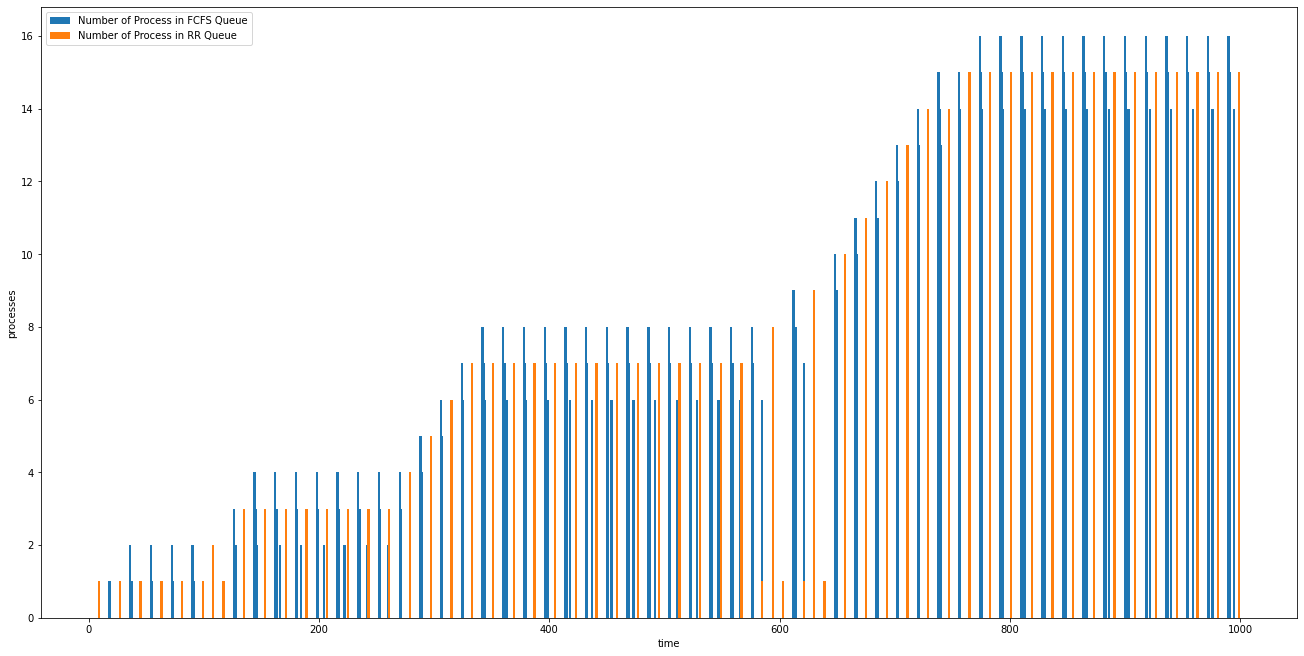

In [118]:
plt.figure(figsize=(18,9), layout='constrained')
plt.bar(df["time"], df["Amount"], label='Number of Process in FCFS Queue', width = 2)
plt.bar(df2["time"], df2["Amount"], label='Number of Process in RR Queue', width = 2)
plt.xlabel("time")
plt.ylabel("processes")
plt.legend()
plt.savefig("{}/stat_plot_mode{}.png".format(path_file, GENERATE_MODE))

### TIME STATISTIC PLOTTING

# DELETE CSV - AVOIDING OVERWRITE

In [117]:
# if os.path.exists(str(stat_file)):
#     os.remove(str(stat_file))
#     print("Delete {}".format(str(stat_file)))
# else:
#     print("{} does not exist".format(str(stat_file)))

# if os.path.exists(str(FCFSQueue_file)):
#     os.remove(str(FCFSQueue_file))
#     print("Delete {}".format(str(FCFSQueue_file)))
# else:
#     print("{} does not exist".format(str(FCFSQueue_file)))

# if os.path.exists(str(RRQueue_file)):
#     os.remove(str(RRQueue_file))
#     print("Delete {}".format(str(RRQueue_file)))
# else:
#     print("{} does not exist".format(str(RRQueue_file)))